## Modelo cluster

In [20]:
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import os
import joblib
import numpy as np
from kneed import KneeLocator
import matplotlib.pyplot as plt

#### Procesamiento de información

In [21]:
# Procesamiento de información

# Leer el archivo CSV
file_path = '../../datos/Raw/contratos_dnp_2020_v1.csv'
df_contratos_v1 = pd.read_csv(file_path)

# Aplicar el filtro
df_contratos_v1 = df_contratos_v1[df_contratos_v1['valor_del_contrato'] != 2870993010534]

# Convertir las columnas de fecha al formato datetime
date_columns = ['fecha_de_firma', 'fecha_de_inicio_del_contrato', 'fecha_de_fin_del_contrato']
for col in date_columns:
    df_contratos_v1[col] = pd.to_datetime(df_contratos_v1[col])

# Calcular la duración del contrato en días
df_contratos_v1['duracion_contrato_dias'] = (df_contratos_v1['fecha_de_fin_del_contrato'] - df_contratos_v1['fecha_de_inicio_del_contrato']).dt.days.fillna(0).replace(0, 1)

# Convertir la columna 'duracion_contrato_dias' a numérica
df_contratos_v1['duracion_contrato_dias'] = df_contratos_v1['duracion_contrato_dias'].astype(int)

# Calcular el valor del contrato por día
df_contratos_v1['valor_contrato_por_dia'] = df_contratos_v1['valor_del_contrato'] / df_contratos_v1['duracion_contrato_dias']

# Extraer el mes de la fecha de firma
df_contratos_v1['fecha_de_firma_month'] = df_contratos_v1['fecha_de_firma'].dt.month

#### pipeline

In [22]:
# Definir las columnas numéricas y categóricas
numeric_features = ['valor_del_contrato', 'fecha_de_firma_month', 'duracion_contrato_dias', 'valor_contrato_por_dia']
categorical_features = ['ciudad', 'tipo_de_contrato', 'estado_contrato', 'modalidad_de_contratacion']

# Definir las transformaciones para las características numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Definir las transformaciones para las características categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combinar las transformaciones en un preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Definir el modelo de clustering
kmeans = KMeans(n_clusters=15, random_state=42)

# Construir el pipeline completo
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('kmeans', kmeans)])

# Entrenar el modelo con los datos
pipeline.fit(df_contratos_v1)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['valor_del_contrato',
                                                   'fecha_de_firma_month',
                                                   'duracion_contrato_dias',
                                                   'valor_contrato_por_dia']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ciudad', 'tipo_de_contrato',
                                                   'estado_contrato',
                                                   'modalidad_de_contratacion'])])),
                ('kmeans', KMeans(n_clusters=15, random_state=42))])

#### Guardardado de información

In [23]:
# Especifica la ruta donde deseas guardar el modelo
ruta_personalizada = '../../datos/model/modelo_cluster.pkl'

# Guardar el pipeline (modelo y preprocesador) en la ruta personalizada
joblib.dump(pipeline, ruta_personalizada)

##########################################

# Obtener las etiquetas de cluster asignadas por DBSCAN
etiquetas_clust = pipeline.named_steps['kmeans'].labels_

# Agregar las etiquetas de cluster al DataFrame original
df_contratos_v1['cluster'] = etiquetas_clust

# Guardar el DataFrame con las etiquetas de cluster
df_contratos_v1.to_excel('../../datos/processed/contratos_dnp_2020_cluster.xlsx', index=False)

#### Número optimo de clusters

El número óptimo de clusters es: 15


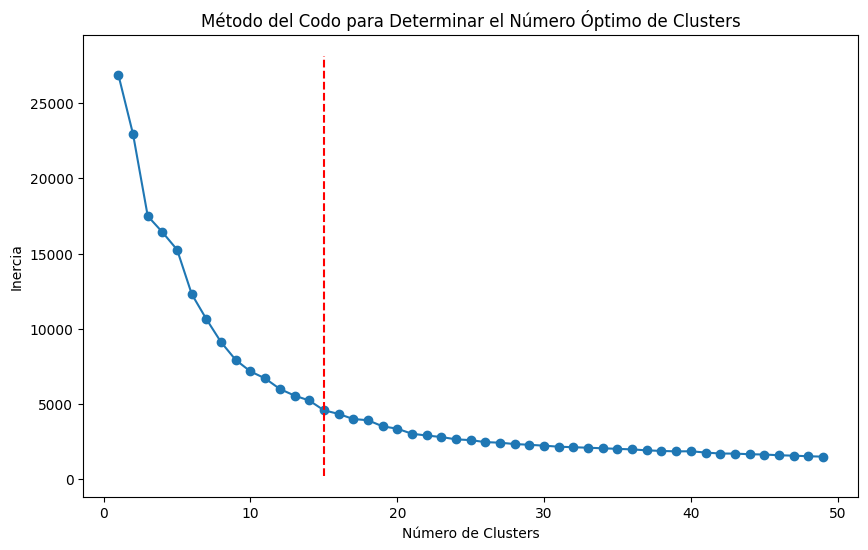

In [24]:
# Rango de número de clusters a probar
num_clusters_range = range(1, 50)
inertia = []

# Iterar sobre el rango y calcular la inercia (distorsión) para cada número de clusters
for num_clusters in num_clusters_range:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('kmeans', kmeans)])
    pipeline.fit(df_contratos_v1)
    inertia.append(kmeans.inertia_)

# Encontrar el punto de codo utilizando KneeLocator
kneedle = KneeLocator(list(num_clusters_range), inertia, curve='convex', direction='decreasing')
optimal_num_clusters = kneedle.elbow

print("El número óptimo de clusters es:", optimal_num_clusters)

# Graficar la curva de codo con el punto de codo identificado
plt.figure(figsize=(10, 6))
plt.plot(num_clusters_range, inertia, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.title('Método del Codo para Determinar el Número Óptimo de Clusters')
plt.vlines(optimal_num_clusters, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='red')
plt.show()


## Estadísticos y gráficas del cluster

In [25]:
# Calcula el número de muestras en cada cluster
df_contratos_v1['cluster'].value_counts() 

cluster
0     1216
2     1153
3      951
13     479
6      479
10     449
11     250
9      212
14      41
12      30
5        8
8        3
4        3
1        1
7        1
Name: count, dtype: int64

In [26]:
# Calcular estadísticas descriptivas por cluster
cluster_stats = df_contratos_v1.groupby('cluster').describe()
print(cluster_stats)

        Unnamed: 0                                                         \
             count         mean     min      25%     50%      75%     max   
cluster                                                                     
0           1216.0  2613.787007     3.0  1239.75  2649.5  3971.00  5273.0   
1              1.0  3366.000000  3366.0  3366.00  3366.0  3366.00  3366.0   
2           1153.0  2631.601041     7.0  1289.00  2597.0  3980.00  5276.0   
3            951.0  2613.998948     0.0  1296.50  2595.0  3923.00  5275.0   
4              3.0  2350.333333  1013.0  1184.00  1355.0  3019.00  4683.0   
5              8.0  2801.500000   477.0  2330.50  2968.0  3446.75  4948.0   
6            479.0  2662.035491    15.0  1460.00  2631.0  3964.50  5259.0   
7              1.0  3889.000000  3889.0  3889.00  3889.0  3889.00  3889.0   
8              3.0  1964.000000    82.0  1480.00  2878.0  2905.00  2932.0   
9            212.0  2659.707547   105.0  1449.25  2532.5  3838.25  5274.0   

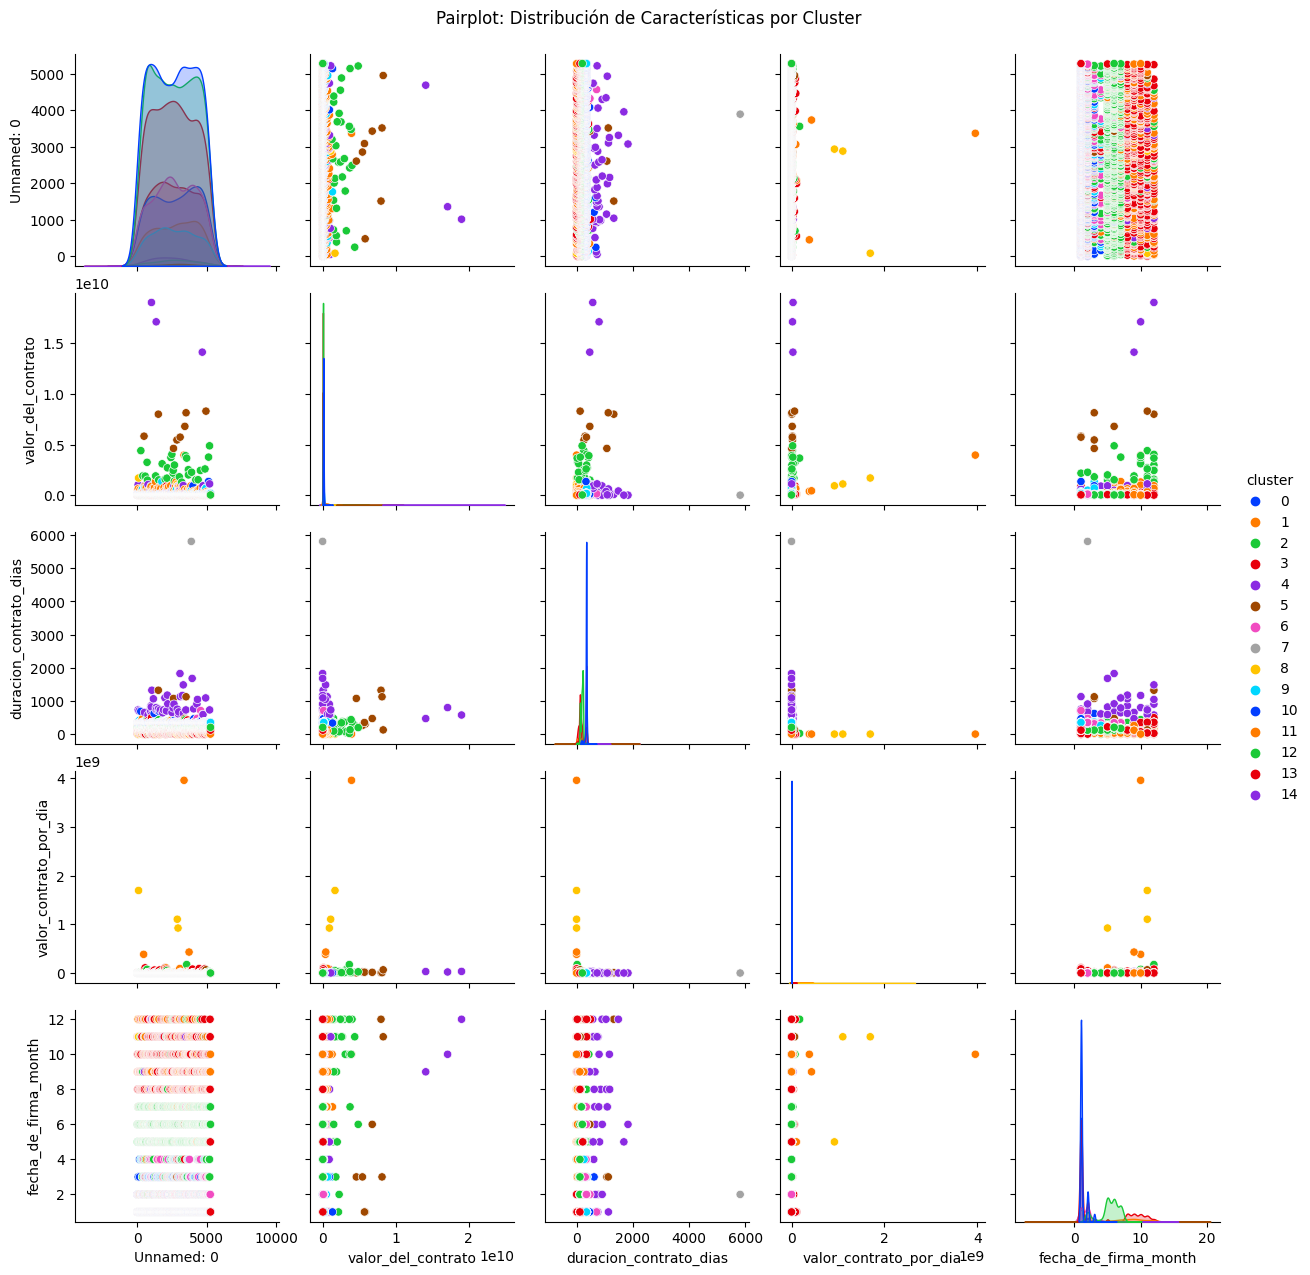

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Ignorar las advertencias
warnings.filterwarnings("ignore")

# Crear un pairplot con colores por cluster
sns.pairplot(df_contratos_v1, hue='cluster', palette='bright', diag_kind='kde', height=2.5)
plt.suptitle('Pairplot: Distribución de Características por Cluster', y=1.02)
plt.show()